# ADCP Analysis

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cmocean
import numpy as np
from geopy import distance
import datetime as dt
import pandas as pd


## Functions 

In [2]:
def dist_shore(adcp, lon0,lat0):   # Calculate the distance from each measurement to the coast and add it as variable to the dataset.
    adcp_surf = adcp.isel(trajectory=0).compute()
    d = xr.zeros_like(adcp_surf.lon)
    #lon0, lat0 = adcp_surf.lon.data[-1], adcp_surf.lat.data[-1]
    for ob, (lon, lat) in enumerate(zip(adcp_surf.lon.data, adcp_surf.lat.data)):
        d[ob] = distance.distance((lon, lat), (lon0, lat0)).m
        adcp["s"] = -d.assign_attrs(
        {"long_name": "distance to coast", "units": "m", "positive": "shoreward"}
    )
    adcp = adcp.set_coords("s").sortby("s")
    #print(f"max distance from coast: {abs(adcp.s.min()).data / 1000:.2f} km")
    return adcp

In [3]:
#Cross-shore and longshore velocity plots functions

def horiz_vel(adcp, title):
    
   
    # Calculate and plot the velocity components parallel and perpendicular to the coast.
    adcp_surf = adcp.isel(trajectory=0).compute()
    # calculations
    dlon = np.deg2rad(adcp_surf.lon.differentiate("obs"))
    dlat = np.deg2rad(adcp_surf.lat.differentiate("obs"))
    lat = np.deg2rad(adcp_surf.lat)
    alpha = np.arctan(dlat / (dlon * np.cos(lat))).mean("obs")  # cruise direction angle
    Ucross = np.cos(alpha) * adcp.U + np.sin(alpha) * adcp.V  # cross-shore vel
    Ulong = -np.sin(alpha) * adcp.U + np.cos(alpha) * adcp.V  # long-shore vel
    adcp["Ucross"] = Ucross.assign_attrs(
        {"long_name": "cross-shore velocity", "units": "m s-1"}
    )
    adcp["Ulong"] = Ulong.assign_attrs(
        {"long_name": "longshore velocity", "units": "m s-1"}
    )
    
    # figure settings
    fig = plt.figure(figsize=(10, 6))
    fig.suptitle(f'{title}', fontsize=14) 
    norm = mcolors.CenteredNorm(halfrange=2)
    cmap = cmocean.cm.balance
    landmask = xr.where(((adcp.U == 0) & (adcp.V == 0)), 1, np.nan)
    S = adcp.s.broadcast_like(adcp.lon)
    
    # cross-shore velocity plot
    ax1 = fig.add_subplot(121)
    p = ax1.pcolormesh(S / 1000, adcp.z, adcp.Ucross, norm=norm, cmap=cmap)
    ax1.pcolormesh(S / 1000, adcp.z, landmask, cmap="binary_r")
    ax1.set_ylabel("depth [m]")
    ax1.set_xlabel("distance from coast [km]")
    ax1.set_title("cross-shore velocity (positive shoreward)")
    ax1.grid()
    plt.xlim([-600, 0])
    
    # alongshore velocity plot
    ax2 = fig.add_subplot(122, sharey=ax1)
    ax2.yaxis.tick_right()
    p2 = ax2.pcolormesh(S / 1000, adcp.z, adcp.Ulong, norm=norm, cmap=cmap)
    ax2.pcolormesh(S / 1000, adcp.z, landmask, cmap="binary_r")
    ax2.set_ylabel("depth [m]", rotation=270, labelpad=15)
    ax2.set_xlabel("distance from coast [km]")
    ax2.set_title("longshore velocity (positive with coast on r.h.s.)")
    ax2.yaxis.set_label_position("right")
    ax2.grid()
    fig.colorbar(
        p, ax=[ax1, ax2], shrink=0.7, orientation="horizontal", label=r"m s$^{-1}$"
    
    )
    plt.xlim([-600, 0])

In [4]:
#vertical velocity plots functions

def vertical_vel(data, title):
    peru = data
    
     # Integrate the continuity equation to find the vertical velocity, starting from the surface downward.
    peru_d = peru.sortby("z", ascending=False)  # sort downward
    
    # # compute dwdz - easy central difference method
    # dwdz = -peru_d.Ucross.differentiate('s')
    norm = mcolors.CenteredNorm(halfrange=2)
    cmap = cmocean.cm.balance
    landmask = xr.where(((peru.U == 0) & (peru.V == 0)), 1, np.nan)
    # compute dwdz - central difference using interpolated values at cell edges
    # slightly more accurate
    landfilter = xr.where(
        ((peru_d.U == 0) & (peru_d.V == 0)), 0, 1
    )  # 0 in land, 1 in ocean
    Ucrossi = peru_d.Ucross.interp(
        obs=peru_d.obs - 0.5
    )  # U at cell boundaries (toward ocean)
    Ucrossi = Ucrossi * landfilter.data
    dUcrossds = Ucrossi.diff("obs") / Ucrossi.s.diff("obs")
    dwdz = -dUcrossds
    
    # integrate dwdz
    peru["w"] = dwdz.cumulative_integrate("z")
    
    # plot the vertical velocity
    ax = plt.axes()
    S, Z = xr.broadcast(peru.s / 1000, peru.z)
    w = ax.pcolormesh(S, Z, peru.w.T, norm=mcolors.CenteredNorm(), cmap=cmap)
    ax.pcolormesh(S, Z, landmask.T, cmap="binary_r")
    plt.title("vertical velocity")
    plt.ylabel("depth [m]")
    plt.xlabel("shoreward distance [km]")
    plt.xlim([-600, 0])
    plt.colorbar(w, label=r"m s$^{-1}$")

## Ship Route

In [5]:
#loading the dta
adcp = xr.open_zarr("/Users/areti/Downloads/results2/somalia/results/adcp.zarr").compute()
#/Users/areti/OneDrive/Desktop/UU/OcenDyn/virtual_ship_data/results/results/adcp.zarr").compute()

# for convenience, define z positive upward
#zu = np.unique(-adcp.z, axis=1).squeeze()  # convert z to 1D and positive upward
zu = np.unique(adcp.z, axis=1).squeeze()  # convert z to 1D 
adcp = adcp.assign_coords({"z": ("trajectory", zu)}).sortby("z")

#bathymetry, thanks Tssa! :)
bathy = xr.open_dataset("/Users/areti/OneDrive/Desktop/UU/OcenDyn/virtual_ship_data/gebco_2024_n11.0_s3.0_w44.0_e57.0.nc")
bathy_masked = bathy.elevation.where(bathy.elevation <= 0)

In [6]:
#to calculate the distance from the shore later, I manually selected these points from the nioz tool. Thes are approximately the coordinads of the 
#shore if you extend our transects. 

#shore lon and lat (extension for transect 1)
lon_1_shore = 48.21
lat_1_shore = 4.97
#shore lon and lat (extension for transect 2)
lon_2_shore = 49.54
lat_2_shore = 7.29
#shore lon and lat (extension for transect 3)
lon_3_shore = 50.72
lat_3_shore = 9.31

Text(0.5, 1.0, 'Ship route from adcp data')

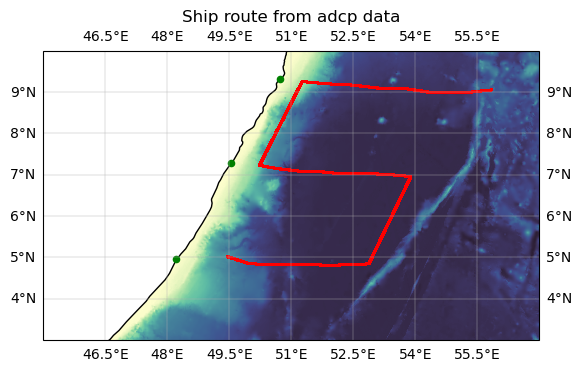

In [32]:
# plot track
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(adcp.lon, adcp.lat, transform=ccrs.PlateCarree(), marker = 'o', s= 1, color = 'red',zorder=2)
#plotshore
ax.scatter(lon_1_shore, lat_1_shore,  transform=ccrs.PlateCarree(), marker = 'o', s= 20, color = 'green',zorder=2)
ax.scatter(lon_2_shore, lat_2_shore, transform=ccrs.PlateCarree(), marker = 'o', s= 20, color = 'green',zorder=2)
ax.scatter(lon_3_shore, lat_3_shore, transform=ccrs.PlateCarree(), marker = 'o', s= 20, color = 'green',zorder=2)
# Plot bathymetry
cm = ax.pcolormesh(bathy.lon, bathy.lat, bathy_masked, cmap=cmocean.cm.deep_r, shading='auto', zorder=1)
ax.coastlines()
ax.gridlines(draw_labels=True,linewidth=0.3)
ax.set_extent((45, 57, 3, 10))
ax.set_title("Ship route from adcp data")


## Slicing the data into transects

So apparently the structure of the data was quite weird (to me), and the observations weren't linearly in time. In this section I am doing a little detour trying to slice our data into the three transects we have. 

The 'time' is a variable/observation in this adcp dataset. I am attempting to access a datapoint via the obs coordinate. We have 1732 observations. 

Based on the dates ('time' variable) I tried to pinpoint which obs (observations? I guess) correspond to the start and end time of each transect. 

In [8]:
#Check the number of obervations 
num_obs = adcp.obs.shape
num_obs[0]
obs = list(range(0,num_obs[0]))
print('Number of observtions is', num_obs[0])

Number of observtions is 1732


In [9]:
#the dates of the transects, first and last measurments 
dates = pd.to_datetime(adcp.time[0][:].values)
dates = pd.DataFrame(dates, columns=['Time'])

#the tim a an offset of 1 to a couple minutes due to the 5min interval between adcp measurments
#Transect 1
trs_1_start = '2024-09-17 23:12:00'
trs_1_end = '2024-09-19 10:02:00'

#Transect 2
trs_2_start = '2024-09-20 02:07:00'
trs_2_end = '2024-09-21 14:12:00'

#Transect 3

trs_3_start = '2024-09-22 05:57:00'
trs_3_end = '2024-09-23 23:12:00'

dates['index'] = obs #keeping the original index, this is the number of observation as saved in the dataset

The observation dates were shuffled (I am not sure why this has happened). Notice in the following cell how the datesj ump back and forth in time!

This means that by just doing data = adcp.sel(obs=slice(0:400)) I am not getting the observations of lets say 2024-09-17 to 2024-09-19 asI expected, but i get some random other dates mixed in with it. 

Ikeep the original index of the obs, sort the Time to be linear and use a new index to actually slice the data like I wanted. This way I end up with an array that has the obs index corresponding to the linear dates I want. So e.g 2024-09-17 to 2024-09-19 and obs = [0,1,2,3,56,57,58,4,5,6...,400] (random numbers for demonstration)

In [10]:
dates[400:410]

,Time,index
400,2024-09-19 08:32:00,400
401,2024-09-19 08:37:00,401
402,2024-09-19 08:42:00,402
403,2024-09-19 08:47:00,403
404,2024-09-19 08:52:00,404
405,2024-09-19 08:57:00,405
406,2024-09-19 09:02:00,406
407,2024-09-19 09:07:00,407
408,2024-09-19 09:12:00,408
409,2024-09-19 09:17:00,409


In [11]:
new_dates = dates.sort_values(by='Time' ,ascending=True) #sort values based on time 
new_dates = new_dates.reset_index() #reset the index in orderto slice pandas frame
#transect 1
trs_1_obs_end = new_dates.loc[new_dates['Time'] == trs_1_end] #find the new index 
obs_ind_1 = new_dates['index'][0:trs_1_obs_end.index[0].item()] #slice pandas frame up until that point and extract thoriginal index/values  of obs
trs1 = adcp.isel(obs = obs_ind_1) #slice the transect from th adcp data

#transect 2
trs_2_obs_start = new_dates.loc[new_dates['Time'] == trs_2_start] 
trs_2_obs_end = new_dates.loc[new_dates['Time'] == trs_2_end] #find the new index 
start2 = trs_2_obs_start.index[0].item()
end2 = trs_2_obs_end.index[0].item()
obs_ind_2 = new_dates['index'][start2:end2] #slice pandas frame up until that point and extract thoriginal index/values  of obs
trs2 = adcp.isel(obs = obs_ind_2) #slice the transect from th adcp data

#transect 3
trs_3_obs_start = new_dates.loc[new_dates['Time'] == trs_3_start] 
trs_3_obs_end = new_dates.loc[new_dates['Time'] == trs_3_end] #find the new index 
start3 = trs_3_obs_start.index[0].item()
end3 = trs_3_obs_end.index[0].item()
obs_ind_3 = new_dates['index'][start3:end3] #slice pandas frame up until that point and extract thoriginal index/values  of obs
trs3 = adcp.isel(obs = obs_ind_3) #slice the transect from th adcp data

In [12]:
trs3

<xarray.Dataset> Size: 442kB
Dimensions:     (trajectory: 37, obs: 495)
Coordinates:
  * obs         (obs) int32 2kB 1233 1234 1235 1236 1237 ... 1724 1725 1726 1727
  * trajectory  (trajectory) int64 296B 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37
    z           (trajectory) float32 148B -150.0 -146.0 -141.9 ... -9.028 -5.0
Data variables:
    U           (trajectory, obs) float32 73kB -0.3056 -0.306 ... 0.9918 0.9907
    V           (trajectory, obs) float32 73kB -0.4819 -0.4819 ... -1.156 -1.154
    lat         (trajectory, obs) float32 73kB 9.267 9.267 9.267 ... 9.062 9.062
    lon         (trajectory, obs) float32 73kB 51.25 51.25 51.25 ... 55.82 55.82
    time        (trajectory, obs) datetime64[ns] 147kB 2024-09-22T05:57:00 .....
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticle_sample_velocity
    parcels_mesh:           spherical
    parcels_version:        3.1.2

Text(0.5, 1.0, 'Transects')

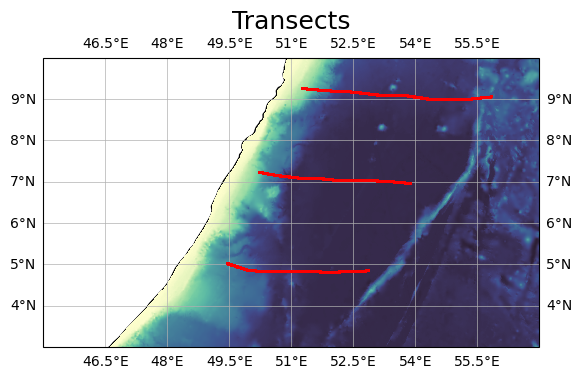

In [38]:
#PLOT TRANSECTS 

# plot track
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(trs1.lon, trs1.lat, transform=ccrs.PlateCarree(), marker = 'o', s= 1, color = 'red',zorder=3)
ax.scatter(trs2.lon, trs2.lat, transform=ccrs.PlateCarree(), marker = 'o', s= 1, color = 'red',zorder=3)
ax.scatter(trs3.lon, trs3.lat, transform=ccrs.PlateCarree(), marker = 'o', s= 1, color = 'red',zorder=3)
# Plot bathymetry
cm = ax.pcolormesh(bathy.lon, bathy.lat, bathy_masked, cmap=cmocean.cm.deep_r, shading='auto', zorder=2)
ax.coastlines()
ax.gridlines(draw_labels=True,linewidth=0.5, zorder=4)
ax.set_extent((45, 57, 3, 10))
ax.set_title("Transects", fontsize=18)


## Velocity components parallel and perpendicular to the coast


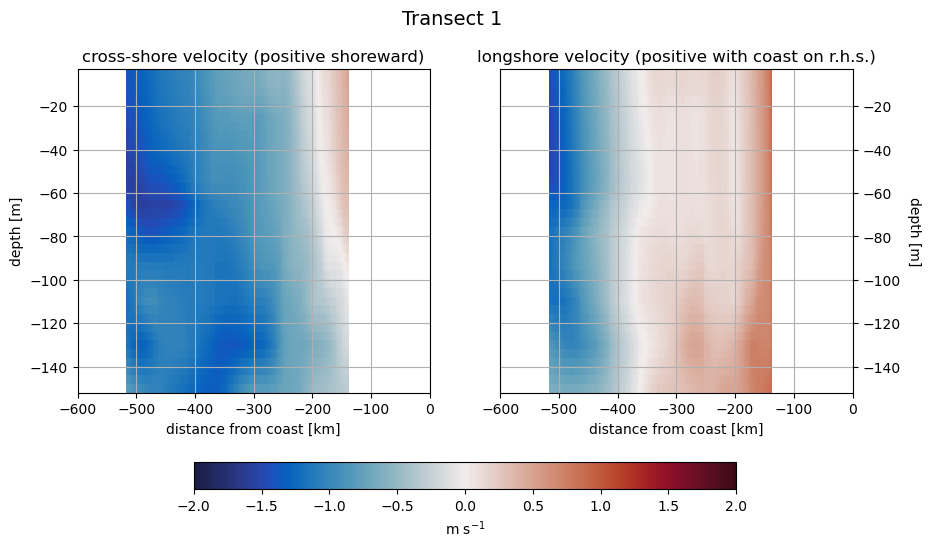

In [14]:
#Transect 1
trs1= dist_shore(adcp=trs1, lon0=lon_1_shore,lat0=lat_1_shore)
horiz_vel(adcp=trs1, title='Transect 1')

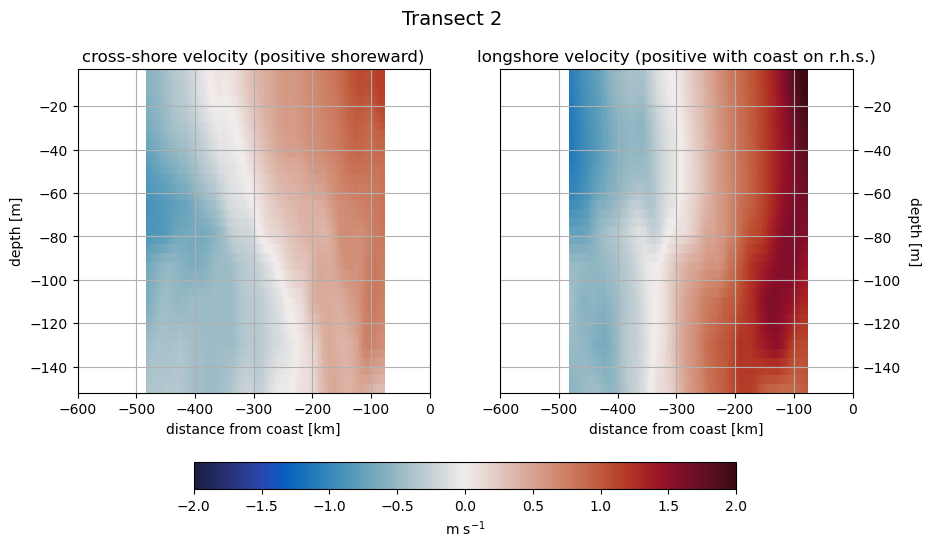

In [15]:
#Transect 2
trs2= dist_shore(adcp=trs2, lon0=lon_2_shore,lat0=lat_2_shore)
horiz_vel(adcp=trs2, title='Transect 2')

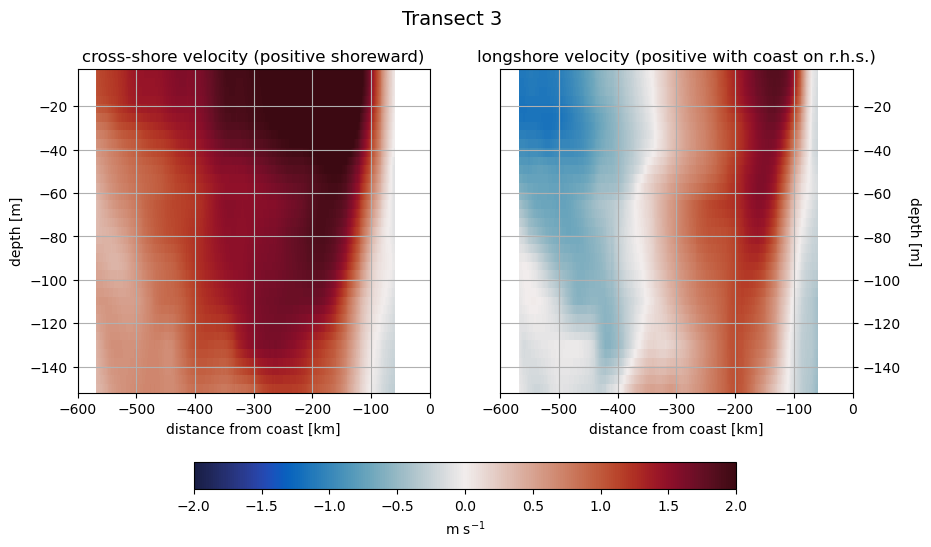

In [16]:
#Transect 3
trs3= dist_shore(adcp=trs3, lon0=lon_3_shore,lat0=lat_3_shore)
horiz_vel(adcp=trs3, title='Transect 3')

## Vertical velocity

C:\Users\areti\anaconda3\envs\dyoc\Lib\site-packages\xarray\core\duck_array_ops.py:208: RuntimeWarning: invalid value encountered in add
  integrand = dx * 0.5 * (y[tuple(slice1)] + y[tuple(slice2)])


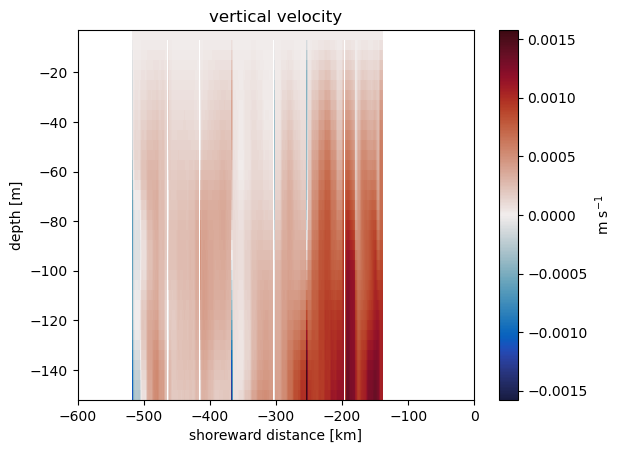

In [17]:
#Transect 1
vertical_vel(data=trs1, title='Transect 1')

C:\Users\areti\anaconda3\envs\dyoc\Lib\site-packages\xarray\core\duck_array_ops.py:208: RuntimeWarning: invalid value encountered in add
  integrand = dx * 0.5 * (y[tuple(slice1)] + y[tuple(slice2)])


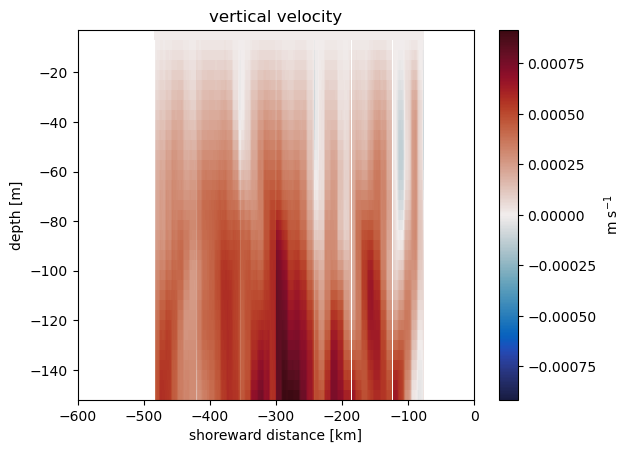

In [18]:
#Transect 2
vertical_vel(data=trs2, title='Transect 2')

C:\Users\areti\anaconda3\envs\dyoc\Lib\site-packages\xarray\core\duck_array_ops.py:208: RuntimeWarning: invalid value encountered in add
  integrand = dx * 0.5 * (y[tuple(slice1)] + y[tuple(slice2)])


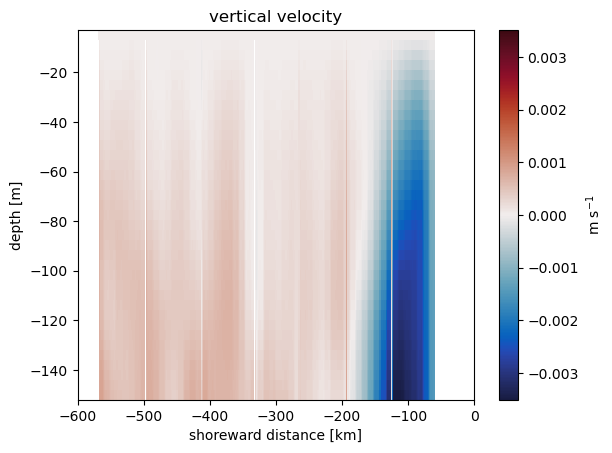

In [19]:
#Transect 3
vertical_vel(data=trs3, title='Transect 3')